# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups   
Sample_185  P00568;Q5T9B7       15.324
Sample_164  Q9UN36-2;Q9UN36-6   16.647
Sample_054  P11279              18.007
Sample_122  P06733              16.781
Sample_078  Q5BIV9              16.984
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups        
Sample_061  B7Z5R6;Q14596;Q14596-2   14.413
Sample_068  P13667                   13.945
Sample_155  J3KRP0                   16.190
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.556
            A0A075B6Q5                 13.226
            A0A075B6R2                 12.341
            A0A075B6S5                 13.348
            A0A087WSY4                 12.559
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.546
            Q9UI40;Q9UI40-2            12.266
            Q9UIW2                     13.590
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.519
            Q9UP79                     12.891
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.360,15.050,16.842,19.863,15.959,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.806,19.067,...,15.528,15.576,14.121,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.969,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.310,17.705,17.039,16.239,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.401,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.280,15.345,17.084,18.708,14.249,19.433,11.457,11.379
Sample_207,15.739,16.877,15.469,16.898,14.964,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.556,...,16.012,15.178,12.307,15.050,16.842,19.863,13.936,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.876,19.067,16.188,...,15.528,15.576,13.034,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.500,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.523,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.430,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.269,15.345,17.084,18.708,14.249,19.433,13.809,13.436
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 361.92it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.62it/s]

100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

100%|██████████| 3/3 [00:00<00:00,  3.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.08it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.35it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.30it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.56it/s]

100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

100%|██████████| 5/5 [00:01<00:00,  3.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.67it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.74it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.78it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.67it/s]

100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.20it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.47it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.37it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.94it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.59it/s]

100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

100%|██████████| 7/7 [00:02<00:00,  2.90it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.31it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.78it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.66it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.64it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.58it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.28it/s]

100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

100%|██████████| 8/8 [00:02<00:00,  3.60it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.77it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.56it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.93it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.66it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.48it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.66it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.21it/s]

100%|██████████| 9/9 [00:03<00:00,  2.02it/s]

100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.05it/s]

 30%|███       | 3/10 [00:01<00:02,  2.42it/s]

 40%|████      | 4/10 [00:01<00:02,  2.15it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.20it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.51it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.64it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.82it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.87it/s]

100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.79it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.19it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.70it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.61it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.43it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.20it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.19it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.05it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.76it/s]

100%|██████████| 11/11 [00:03<00:00,  2.58it/s]

100%|██████████| 11/11 [00:03<00:00,  3.12it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.13it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.16it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.96it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.59it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.50it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.61it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.73it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.65it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.49it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.35it/s]

100%|██████████| 12/12 [00:04<00:00,  2.19it/s]

100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.12it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.89it/s]

 31%|███       | 4/13 [00:01<00:03,  2.79it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.43it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.22it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.23it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.15it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.21it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.41it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.45it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.50it/s]

100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

100%|██████████| 13/13 [00:05<00:00,  2.51it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.21it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.04it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.82it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.84it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.79it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.75it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.68it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.79it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.78it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.78it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.45it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.33it/s]

100%|██████████| 14/14 [00:05<00:00,  2.28it/s]

100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.51it/s]

 20%|██        | 3/15 [00:00<00:03,  3.72it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.26it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.99it/s]

 40%|████      | 6/15 [00:01<00:03,  2.97it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.90it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.95it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.48it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.30it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.25it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.21it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.32it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.40it/s]

100%|██████████| 15/15 [00:05<00:00,  2.51it/s]

100%|██████████| 15/15 [00:05<00:00,  2.65it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.066 0.024          0.724 0.383       0.100   
2             0.004 0.003      0.055 0.020          0.723 0.100       0.557   
3             0.005 0.003      0.049 0.012          0.772 0.109       0.711   
4             0.005 0.003      0.057 0.019          0.767 0.098       0.730   
5             0.004 0.002      0.050 0.010          0.813 0.090       0.744   
6             0.004 0.003      0.050 0.009          0.817 0.093       0.774   
7             0.004 0.002      0.055 0.019          0.817 0.094       0.779   
8             0.007 0.005      0.086 0.032          0.812 0.093       0.782   
9             0.005 0.004      0.059 0.032          0.822 0.088       0.845   
10            0.005 0.004      0.060 0.021          0.820 0.086       0.835   
11            0.006 0.005      0.071 0.029          0.825 0.079       0.821   
12            0.005 0.003      0.056 0.019          0.822 0.079       0.822   
13            0.006 0.005      0.062 0.021          0.815 0.080       0.811   
14            0.004 0.003      0.043 0.019          0.810 0.083       0.805   
15            0.006 0.005      0.068 0.026          0.809 0.079       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.169 0.122                  0.543 0.038        0.861   
2          0.116   0.622 0.091                  0.698 0.063        0.798   
3          0.118   0.733 0.086                  0.775 0.069        0.873   
4          0.119   0.742 0.084                  0.781 0.067        0.883   
5          0.100   0.772 0.074                  0.807 0.061        0.902   
6          0.092   0.791 0.072                  0.822 0.060        0.910   
7          0.090   0.793 0.072                  0.823 0.060        0.908   
8          0.096   0.792 0.073                  0.823 0.062        0.908   
9          0.099   0.828 0.069                  0.853 0.061        0.921   
10         0.100   0.823 0.070                  0.849 0.061        0.919   
11         0.101   0.819 0.069                  0.846 0.059        0.922   
12         0.099   0.818 0.068                  0.845 0.059        0.920   
13         0.095   0.809 0.068                  0.837 0.059        0.919   
14         0.092   0.804 0.067                  0.832 0.058        0.918   
15         0.096   0.804 0.067                  0.833 0.058        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.829 0.087        210.000 0.000  
2          0.073                  0.722 0.092        210.000 0.000  
3          0.061                  0.837 0.081        210.000 0.000  
4          0.055                  0.850 0.072        210.000 0.000  
5          0.048                  0.882 0.057        210.000 0.000  
6          0.049                  0.891 0.058        210.000 0.000  
7          0.051                  0.888 0.060        210.000 0.000  
8          0.051                  0.889 0.060        210.000 0.000  
9          0.046                  0.905 0.051        210.000 0.000  
10         0.047                  0.901 0.054        210.000 0.000  
11         0.046                  0.905 0.053        210.000 0.000  
12         0.046                  0.904 0.053        210.000 0.000  
13         0.047                  0.901 0.055        210.000 0.000  
14         0.046                  0.900 0.053        210.000 0.000  
15         0.047                  0.900 0.052 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 386.14it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.60it/s]

100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.39it/s]

100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.27it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.31it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.12it/s]

100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.21it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.57it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.12it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.46it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.89it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.65it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.53it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.27it/s]

100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.63it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.40it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.78it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.55it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.86it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.74it/s]

100%|██████████| 8/8 [00:03<00:00,  1.73it/s]

100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.85it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.83it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.87it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.73it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.80it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.70it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.70it/s]

100%|██████████| 9/9 [00:03<00:00,  2.74it/s]

100%|██████████| 9/9 [00:03<00:00,  2.90it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.49it/s]

 30%|███       | 3/10 [00:00<00:01,  3.95it/s]

 40%|████      | 4/10 [00:01<00:02,  2.94it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.33it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.09it/s]

 70%|███████   | 7/10 [00:02<00:01,  1.95it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.07it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.14it/s]

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.80it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.20it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.78it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.64it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.65it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.71it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.83it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.53it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.53it/s]

100%|██████████| 11/11 [00:03<00:00,  2.65it/s]

100%|██████████| 11/11 [00:03<00:00,  2.75it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.49it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.73it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.39it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.99it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.69it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.58it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.62it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.22it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.04it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.89it/s]

100%|██████████| 12/12 [00:05<00:00,  1.95it/s]

100%|██████████| 12/12 [00:05<00:00,  2.39it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.26it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.86it/s]

 31%|███       | 4/13 [00:01<00:03,  2.89it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.37it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.95it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.82it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.93it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.09it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.14it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.14it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.16it/s]

100%|██████████| 13/13 [00:05<00:00,  2.23it/s]

100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.59it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.89it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.50it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.53it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.52it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.45it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.44it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.42it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.44it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.50it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.62it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.57it/s]

100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.70it/s]

 20%|██        | 3/15 [00:00<00:03,  3.42it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.01it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.63it/s]

 40%|████      | 6/15 [00:02<00:03,  2.43it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.34it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.41it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.50it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.60it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.68it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.71it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.67it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.76it/s]

100%|██████████| 15/15 [00:05<00:00,  2.76it/s]

100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.063 0.022          0.087 0.248       0.009   
2             0.005 0.004      0.066 0.026          0.628 0.206       0.273   
3             0.005 0.003      0.063 0.023          0.662 0.131       0.425   
4             0.006 0.006      0.066 0.031          0.654 0.133       0.452   
5             0.005 0.004      0.066 0.032          0.755 0.095       0.643   
6             0.006 0.004      0.064 0.022          0.753 0.089       0.659   
7             0.004 0.003      0.054 0.017          0.761 0.090       0.662   
8             0.004 0.002      0.054 0.022          0.812 0.086       0.813   
9             0.006 0.005      0.068 0.031          0.814 0.086       0.811   
10            0.004 0.000      0.046 0.003          0.802 0.088       0.808   
11            0.006 0.006      0.068 0.024          0.794 0.091       0.806   
12            0.005 0.003      0.054 0.014          0.813 0.091       0.826   
13            0.004 0.002      0.049 0.008          0.815 0.093       0.825   
14            0.005 0.004      0.058 0.022          0.814 0.093       0.823   
15            0.007 0.006      0.068 0.026          0.799 0.089       0.790   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.855   
2          0.126   0.361 0.135                  0.575 0.050        0.696   
3          0.109   0.505 0.091                  0.627 0.054        0.680   
4          0.121   0.522 0.100                  0.633 0.064        0.676   
5          0.116   0.690 0.093                  0.746 0.070        0.817   
6          0.111   0.698 0.086                  0.750 0.066        0.815   
7          0.112   0.702 0.083                  0.754 0.062        0.812   
8          0.107   0.808 0.075                  0.837 0.063        0.902   
9          0.109   0.807 0.074                  0.836 0.063        0.903   
10         0.110   0.800 0.077                  0.830 0.065        0.906   
11         0.102   0.796 0.075                  0.825 0.064        0.904   
12         0.096   0.816 0.072                  0.842 0.061        0.918   
13         0.095   0.816 0.073                  0.842 0.063        0.918   
14         0.096   0.814 0.072                  0.841 0.062        0.916   
15         0.108   0.790 0.079                  0.822 0.065        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.087        210.000 0.000  
2          0.099                  0.613 0.114        210.000 0.000  
3          0.075                  0.612 0.089        210.000 0.000  
4          0.081                  0.617 0.090        210.000 0.000  
5          0.069                  0.791 0.088        210.000 0.000  
6          0.069                  0.785 0.091        210.000 0.000  
7          0.071                  0.782 0.093        210.000 0.000  
8          0.049                  0.878 0.056        210.000 0.000  
9          0.050                  0.880 0.058        210.000 0.000  
10         0.050                  0.885 0.058        210.000 0.000  
11         0.050                  0.886 0.057        210.000 0.000  
12         0.045                  0.899 0.053        210.000 0.000  
13         0.045                  0.899 0.052        210.000 0.000  
14         0.045                  0.897 0.053        210.000 0.000  
15         0.044                  0.898 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 976.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 17.35it/s]

100%|██████████| 2/2 [00:00<00:00, 17.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 19.99it/s]

100%|██████████| 3/3 [00:00<00:00, 15.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.17it/s]

100%|██████████| 4/4 [00:00<00:00, 11.98it/s]

100%|██████████| 4/4 [00:00<00:00, 12.52it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 19.60it/s]

 80%|████████  | 4/5 [00:00<00:00, 11.91it/s]

100%|██████████| 5/5 [00:00<00:00, 11.68it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.13it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 12.50it/s]

100%|██████████| 6/6 [00:00<00:00, 13.02it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.21it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.18it/s]

100%|██████████| 7/7 [00:00<00:00, 16.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 15.91it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.20it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.37it/s]

100%|██████████| 8/8 [00:00<00:00, 14.04it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 25.26it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 22.70it/s]

100%|██████████| 9/9 [00:00<00:00, 21.54it/s]

100%|██████████| 9/9 [00:00<00:00, 22.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 28.63it/s]

 60%|██████    | 6/10 [00:00<00:00, 19.58it/s]

 90%|█████████ | 9/10 [00:00<00:00, 17.43it/s]

100%|██████████| 10/10 [00:00<00:00, 18.83it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 26.42it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 20.22it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 17.16it/s]

100%|██████████| 11/11 [00:00<00:00, 19.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.36it/s]

 33%|███▎      | 4/12 [00:00<00:00, 17.08it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.41it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 18.29it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 19.25it/s]

100%|██████████| 12/12 [00:00<00:00, 18.71it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 29.11it/s]

 46%|████▌     | 6/13 [00:00<00:00, 21.67it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 21.30it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 20.58it/s]

100%|██████████| 13/13 [00:00<00:00, 20.95it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 25.14it/s]

 43%|████▎     | 6/14 [00:00<00:00, 19.25it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 19.40it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 20.43it/s]

100%|██████████| 14/14 [00:00<00:00, 20.52it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 29.45it/s]

 40%|████      | 6/15 [00:00<00:00, 24.77it/s]

 60%|██████    | 9/15 [00:00<00:00, 21.56it/s]

 80%|████████  | 12/15 [00:00<00:00, 20.98it/s]

100%|██████████| 15/15 [00:00<00:00, 16.84it/s]

100%|██████████| 15/15 [00:00<00:00, 19.02it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.059 0.028          0.000 0.000       0.000   
2             0.005 0.005      0.072 0.034          0.657 0.095       0.503   
3             0.005 0.004      0.062 0.024          0.671 0.108       0.522   
4             0.005 0.003      0.053 0.015          0.649 0.106       0.500   
5             0.005 0.004      0.061 0.021          0.647 0.118       0.493   
6             0.004 0.002      0.047 0.012          0.648 0.106       0.497   
7             0.005 0.003      0.056 0.019          0.649 0.109       0.551   
8             0.004 0.002      0.042 0.015          0.660 0.099       0.574   
9             0.003 0.003      0.038 0.019          0.663 0.105       0.579   
10            0.003 0.001      0.038 0.011          0.642 0.079       0.643   
11            0.002 0.000      0.027 0.001          0.645 0.082       0.636   
12            0.003 0.000      0.029 0.005          0.647 0.082       0.640   
13            0.003 0.001      0.030 0.012          0.658 0.086       0.638   
14            0.003 0.001      0.029 0.006          0.651 0.088       0.624   
15            0.003 0.001      0.029 0.004          0.643 0.085       0.625   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.740   
2          0.113   0.560 0.084                  0.652 0.054        0.702   
3          0.114   0.578 0.090                  0.663 0.065        0.717   
4          0.105   0.554 0.077                  0.645 0.057        0.712   
5          0.103   0.550 0.081                  0.641 0.062        0.701   
6          0.112   0.553 0.088                  0.646 0.061        0.700   
7          0.111   0.589 0.089                  0.664 0.066        0.750   
8          0.109   0.606 0.080                  0.675 0.061        0.753   
9          0.114   0.610 0.082                  0.678 0.065        0.751   
10         0.099   0.637 0.069                  0.688 0.059        0.794   
11         0.106   0.634 0.071                  0.688 0.059        0.791   
12         0.099   0.638 0.068                  0.690 0.058        0.788   
13         0.104   0.641 0.069                  0.694 0.058        0.792   
14         0.107   0.631 0.076                  0.687 0.061        0.787   
15         0.110   0.628 0.079                  0.684 0.065        0.782   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.688 0.085        210.000 0.000  
2          0.067                  0.679 0.071        210.000 0.000  
3          0.073                  0.679 0.080        210.000 0.000  
4          0.073                  0.670 0.080        210.000 0.000  
5          0.073                  0.662 0.083        210.000 0.000  
6          0.075                  0.664 0.083        210.000 0.000  
7          0.069                  0.709 0.077        210.000 0.000  
8          0.071                  0.692 0.091        210.000 0.000  
9          0.071                  0.692 0.090        210.000 0.000  
10         0.059                  0.751 0.073        210.000 0.000  
11         0.060                  0.746 0.072        210.000 0.000  
12         0.059                  0.743 0.073        210.000 0.000  
13         0.060                  0.747 0.076        210.000 0.000  
14         0.061                  0.733 0.083        210.000 0.000  
15         0.061                  0.728 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,15,5
score_time,8,11,2
test_precision,11,13,3
test_recall,9,12,10
test_f1,9,13,13
test_balanced_accuracy,9,13,13
test_roc_auc,11,12,10
test_average_precision,11,12,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.40it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.14it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.46it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.08it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.85it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.94it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.93it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.13it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.28it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.37it/s]

100%|██████████| 12/12 [00:02<00:00,  4.43it/s]

100%|██████████| 12/12 [00:02<00:00,  4.61it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 25.41it/s]

 60%|██████    | 6/10 [00:00<00:00, 20.65it/s]

 90%|█████████ | 9/10 [00:00<00:00, 20.03it/s]

100%|██████████| 10/10 [00:00<00:00, 20.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.57it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.86it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.06it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.77it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.54it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.40it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.38it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.31it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.30it/s]

100%|██████████| 11/11 [00:01<00:00,  5.32it/s]

100%|██████████| 11/11 [00:01<00:00,  5.65it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


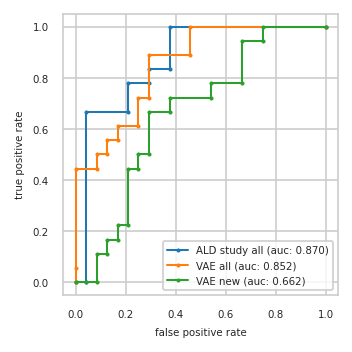

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.667   0.000 0.444   0.083 0.000
3          0.208 0.667   0.083 0.444   0.083 0.111
4          0.208 0.778   0.083 0.500   0.125 0.111
5          0.292 0.778   0.125 0.500   0.125 0.167
6          0.292 0.833   0.125 0.556   0.167 0.167
7          0.375 0.833   0.167 0.556   0.167 0.222
8          0.375 1.000   0.167 0.611   0.208 0.222
9          1.000 1.000   0.250 0.611   0.208 0.444
10           NaN   NaN   0.250 0.722   0.250 0.444
11           NaN   NaN   0.292 0.722   0.250 0.500
12           NaN   NaN   0.292 0.889   0.292 0.500
13           NaN   NaN   0.458 0.889   0.292 0.667
14           NaN   NaN   0.458 1.000   0.375 0.667
15           NaN   NaN   1.000 1.000   0.375 0.722
16           NaN   NaN     NaN   NaN   0.542 0.722
17           NaN   NaN     NaN   NaN   0.542 0.778
18           NaN   NaN     NaN   NaN   0.667 0.778
19           NaN   NaN     NaN   NaN   0.667 0.944
20           NaN   NaN     NaN   NaN   0.750 0.944
21           NaN   NaN     NaN   NaN   0.750 1.000
22           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,G3V4U0;G3XA98;Q9UBX5,Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9U...,H0Y7T8;P49418;P49418-2
2,A0A0B4J1V0,Q92765,Q9NUQ9
3,P61981,Q9Y2T3;Q9Y2T3-3,Q96GD0
4,Q99983,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P04075,C9JF17;P05090,J3KSJ8;Q9UD71;Q9UD71-2
6,P14174,P04075,P31321
7,Q9Y2T3;Q9Y2T3-3,P63104,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,P08294,Q96GD0,A0A075B7B8


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


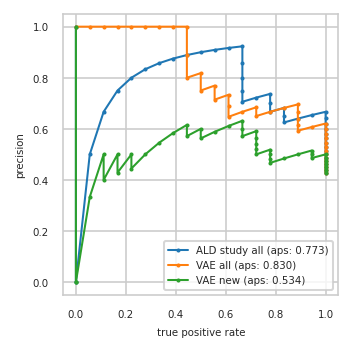

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.600 1.000     0.467 0.778
13         0.621 1.000     0.621 1.000     0.483 0.778
14         0.643 1.000     0.607 0.944     0.500 0.778
15         0.667 1.000     0.593 0.889     0.519 0.778
16         0.654 0.944     0.615 0.889     0.500 0.722
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.625 0.833     0.667 0.889     0.542 0.722
19         0.652 0.833     0.696 0.889     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.667 0.778     0.667 0.778     0.571 0.667
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.737 0.778     0.684 0.722     0.632 0.667
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.706 0.667     0.647 0.611     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.857 0.667     0.714 0.556     0.571 0.444
29         0.923 0.667     0.769 0.556     0.615 0.444
30         0.917 0.611     0.750 0.500     0.583 0.389
31         0.909 0.556     0.818 0.500     0.545 0.333
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.889 0.444     0.444 0.222
34         0.875 0.389     1.000 0.444     0.500 0.222
35         0.857 0.333     1.000 0.389     0.429 0.167
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


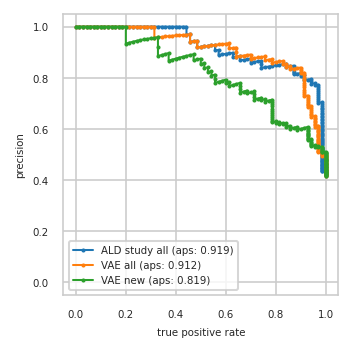

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


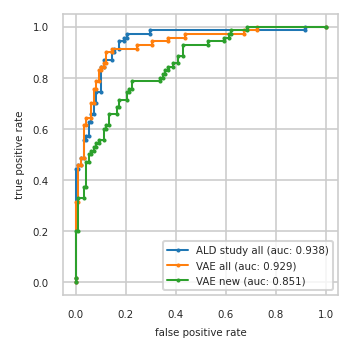

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}